# Graph Figure Generation Notebook

This notebook generates two main figures:
1. The main figure
2. The figure for the input state

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# creating GNN figure

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import torch

import graph_rendering
import graph_rl
import pursuit_evasion_nn_agents
import pursuit_evasion_simulation
import scenarios
import landscape as landscaping

# Constructing information to render GNN
# Draw circles
pos = [
    (1, 1),
    (2, 3),
    (3, 1.5),
    (4, 3),
]
num_vecs = len(pos)
# Generate vectors
vecs = [
    [
        (0, 0, 1.),
        (0, 1., 1.),
        (1., 0, 1.),
        (0, 1., 0),
    ]
]
num_layers = 1
for layer in range(num_layers):
    previous_vectors = vecs[-1]
    vecs.append([])
    for i in range(num_vecs):
        # add noise
        initial_vec = previous_vectors[i]
        get_noise = lambda: np.random.normal(0, 0.5 / num_layers)
        vecs[-1].append((initial_vec[0] + get_noise(), initial_vec[1] + get_noise(), initial_vec[2] + get_noise()))
        vecs[-1][-1] = (max(0, vecs[-1][-1][0]), max(0, vecs[-1][-1][1]), max(0, vecs[-1][-1][2]))
cmap = cm.get_cmap("inferno")

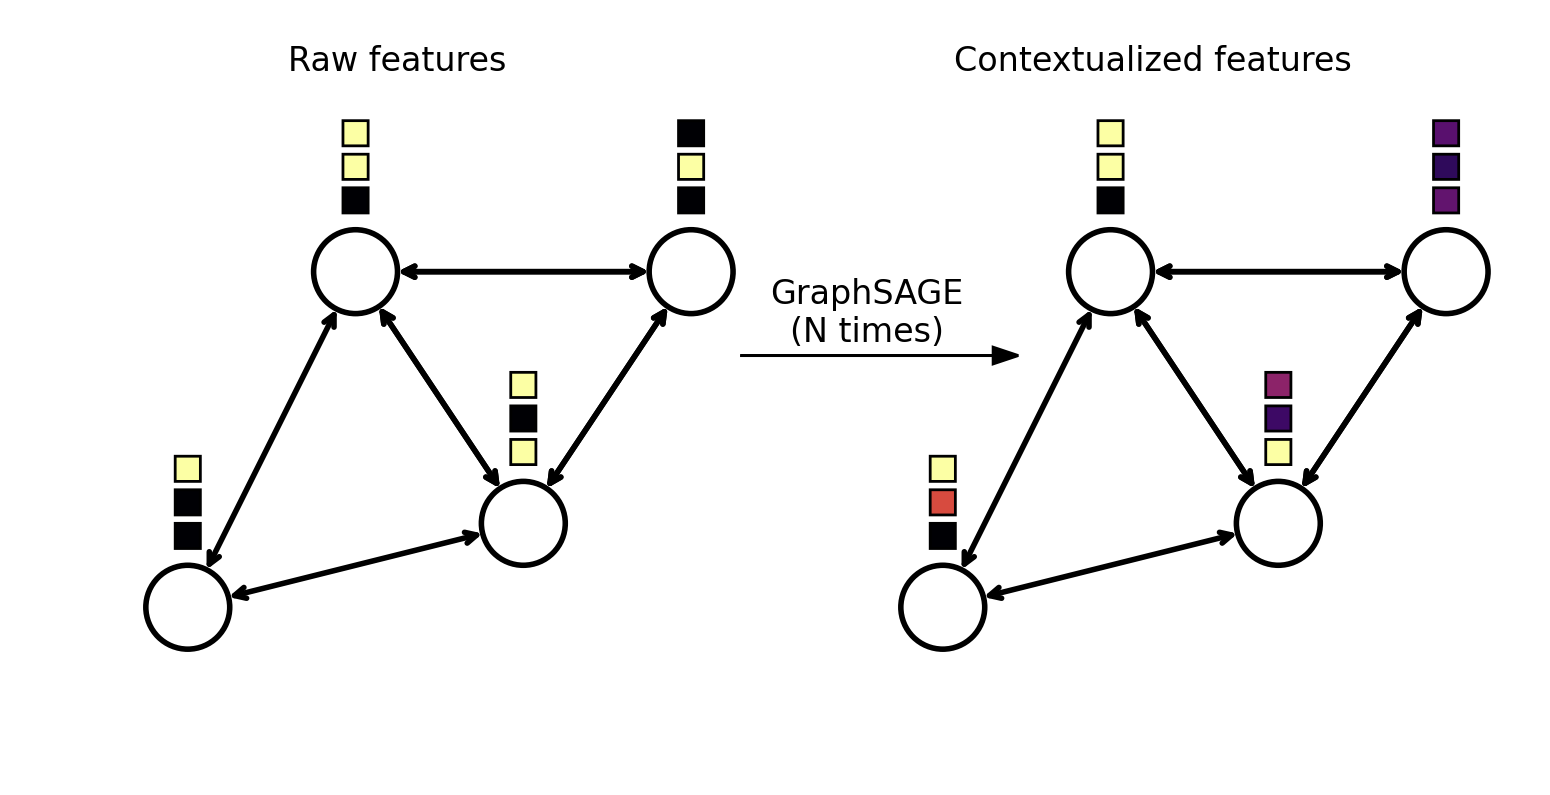

In [2]:
# Rendering the GNN itself.
# We render the same GNN, at different offsets to show how the node vectors evolve over time.

fig, ax = plt.subplots(figsize=(10, 5), dpi=200)

graph_width = 4
graph_width_pad = 1
graph_render_hop_size = 4.5
circle_radius = 0.25
vector_item_width = 0.15
vector_item_height = 0.15
vector_item_vertical_margin = 0.05
vector_margin_to_node = 0.1

for layer in range(len(vecs)):
    x_offset = layer * graph_render_hop_size
    circles = []
    lines = []
    for i in range(len(pos)):
        x, y = pos[i]
        vec = vecs[layer][i]
        # Create circles
        circle = mpatches.Circle((x + x_offset, y), circle_radius, facecolor="none", edgecolor="black", linewidth=2)
        circles.append(circle)
        # Create lines between each circle and two closest neighbors
        dists = [
            ((x - x2) ** 2 + (y - y2) ** 2) ** 0.5
            for x2, y2 in pos
        ]
        closest = sorted(zip(dists, pos), key=lambda x: x[0])[1:3]
        for dist, (x2, y2) in closest:
            dx = x2 - x
            dy = y2 - y
            udx = dx / dist
            udy = dy / dist
            line = mpatches.ConnectionPatch(
                (x + udx * circle_radius + x_offset, y + udy * circle_radius), (x2 - udx * circle_radius + x_offset, y2 - udy * circle_radius), "data", "data", arrowstyle="<->", linewidth=2
            )
            lines.append(line)
        # Add mini vectors above each circle, represented as vertical rectangles with boxes
        for dim in range(3):
            color = cmap(vec[dim])
            dim_y_offset = dim * (vector_item_height + vector_item_vertical_margin)
            rect = mpatches.Rectangle(
                (
                    x - vector_item_width / 2 + x_offset,
                    y + circle_radius + vector_margin_to_node + dim_y_offset,
                ),
                vector_item_width,
                vector_item_height,
                facecolor=color,
                edgecolor="black",
                linewidth=1,
                antialiased=True,
                # https://stackoverflow.com/questions/13822950/artifacts-in-matplotlib-patch-plotting
                snap=False,
            )
            ax.add_patch(rect)

    for circle in circles:
        ax.add_patch(circle)
    for line in lines:
        ax.add_patch(line)

    # Draw arrow
    if layer < len(vecs) - 1:
        x_offset = (layer + 0.9) * graph_render_hop_size
        ax.arrow(
            x=x_offset + 0.25,
            y=2.5,
            dx=1.5,
            dy=0,
            head_width=0.1,
            fc="k",
        )
        # Draw text above arrow to indicate GraphSAGE
        ax.text(
            x=x_offset + 1,
            y=2.75,
            s="GraphSAGE\n(N times)",
            horizontalalignment="center",
            verticalalignment="center",
            fontsize=12,
        )

# Write "raw features" over first graph

ax.text(
    x=graph_render_hop_size * 0.5,
    y=4.25,
    s="Raw features",
    horizontalalignment="center",
    verticalalignment="center",
    fontsize=12,
)
ax.text(
    x=graph_render_hop_size * 1.5,
    y=4.25,
    s="Contextualized features",
    horizontalalignment="center",
    verticalalignment="center",
    fontsize=12,
)
    
ax.set_xlim(0, graph_render_hop_size * len(vecs))
ax.set_ylim(0, graph_render_hop_size)
ax.set_aspect("equal")
ax.axis('off')
plt.show()

# Rendering prioritized sampling technique

This will work by having a ton of graphs overlaid with each other, representing different training runs. Then, we will illustrate that the training distribution shifts towards more difficult samples.

In [2]:
agent = pursuit_evasion_nn_agents.PursuitGraphModel(
    dim=64,
    layers=4,
    keys=[
        'evader_visited',
        'goal_distance',
        'decoy_distance',
        'remaining_time',
    ],
    modeling_approach='sage'
)
agent.load_state_dict(
    torch.load(
        "models/v25.1_varying_timeout_steps_prioritized/sage/ambiguity/distance_metric='shortest_path:0.0'_graph_depth=4_feed_forward_layers=4/2023-08-01_09-15-13/model.pt"
    )
)

<All keys matched successfully>

In [3]:
landscape = landscaping.load_landscape('gridworlds/square_rect_based/8x8C.tmx', vf_movement_penalty=0, vf_goal_initial_value=1, vf_discount_factor=0.99)

In [6]:

def get_random_scenario(landscape, deceptiveness: float, movement_cost: float, min_start_end_distance=0):
    nodes = list(landscape.graph.nodes)
    # choose random corners
    # nodes = [(0, 0), (4, 0), (4, 4), (0, 4)]
    distance = -1
    while distance < min_start_end_distance:
        start_idx, goal_idx, decoy_goal_idx = np.random.choice(len(nodes), size=3, replace=False)
        distance = landscape.distance_matrix[nodes[goal_idx]][nodes[start_idx]]
    # randomly select an amount of remaining time
    timeout_steps = round(np.random.uniform(*scenarios.get_min_and_max_exaggeration_episode_durations(landscape, nodes[start_idx], nodes[goal_idx], nodes[decoy_goal_idx])))
    return scenarios.Scenario(
        name='{}-{}-{}'.format(landscape.name, nodes[goal_idx], nodes[decoy_goal_idx]),
        landscape=landscape,
        start_position=nodes[start_idx],
        goal_position=nodes[goal_idx],
        decoy_goal_position=nodes[decoy_goal_idx],
        deceptiveness=deceptiveness,
        movement_cost=movement_cost,
        timeout_steps=timeout_steps,
    )

In [7]:
images = []
num_images = 4

for deceptiveness_fraction in [i / (num_images - 1) for i in range(num_images)]:
    scenario = get_random_scenario(
        landscape,
        deceptiveness=0,
        movement_cost=0,
        min_start_end_distance=10,
    )
    env = pursuit_evasion_simulation.create_environment_from_scenario(
        scenario=scenario,
        deception_type='none',
        differentiate_deception=False,
        deception_gamma=0.95,
        visibility=4,
        distance_metric='shortest_path'
    )
    steps = graph_rl.sample_episode(env, graph_rl.model_as_policy(agent))
    episode = graph_rl.Episode(steps, scenario)
    print("Success:", episode.steps[-1].info['goal_bonus'] > 0)

    path = [scenario.start_position] + [steps[i].action for i in range(len(steps))]

    # Render each of these paths
    rendered = graph_rendering.render_path_v2(
        graph=landscape.graph,
        pos=landscape.layout,
        image_size=600,
        path=path,
        background_color=(255, 255, 255),
        custom_node_colors={n: (254, 254, 254) for n in landscape.graph.nodes if n not in path},
        node_size=15,
        edge_thickness=2,
        outline_thickness=2
    )
    images.append(rendered)

Success: True
Success: True
Success: True
Success: True


In [8]:
# Draw a stack of these images
def render_image_stack(images, decay_amount=0.7):
    diagonal_offset = 25
    image_size = 600
    num_images = len(images)
    stacked_image = np.ones((diagonal_offset * num_images + image_size, diagonal_offset * num_images + image_size, 3))

    for i, image in enumerate(images):
        if image is None:
            continue
        
        stacked_image = stacked_image * decay_amount + (1 - decay_amount)
        mask = image != 255
        stacked_image[
            i * diagonal_offset:i * diagonal_offset + image_size,
            (num_images - i) * diagonal_offset:(num_images - i) * diagonal_offset + image_size,
            :
        ][mask] = image[mask] / 255

    return stacked_image


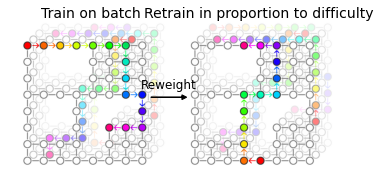

In [9]:
stacked_image_0 = render_image_stack(images, decay_amount=0.5)
stacked_image_1 = render_image_stack(
    [images[i] if i < 4 else None for i in range(len(images))][::-1],
    decay_amount=0.5,
)
# # Show extraction
# extracted = np.ones_like(stacked_image_0)
# subimage_size = images[0].shape[0] // 2
# i = 0
# centering_offset = (stacked_image_0.shape[0] - images[0].shape[0]) // 2
# for dx in [0, 1]:
#     for dy in [0, 1]:
#         image = images[i]
#         extracted[
#             centering_offset + dx * subimage_size:centering_offset + dx * subimage_size + subimage_size,
#             centering_offset + dy * subimage_size:centering_offset + dy * subimage_size + subimage_size,
#             :
#         ] = image[dx::2, dy::2, :] / 255
#         i += 1

combo = np.concatenate([stacked_image_0, stacked_image_1], axis=1)

plt.imshow(combo)
# add text that says "batch"
plt.text(
    x=stacked_image_0.shape[1] / 2,
    y=0,
    s='Train on batch',
    fontsize=14,
    horizontalalignment='center',
    verticalalignment='center',
)
# add text that says "retrain on most important"
plt.text(
    x=3 * stacked_image_0.shape[1] / 2,
    y=0,
    s='Retrain in proportion to difficulty',
    fontsize=14,
    horizontalalignment='center',
    verticalalignment='center',
)
# Draw arrow connecting the two
plt.arrow(
    x=stacked_image_0.shape[1] - 100,
    y=stacked_image_0.shape[0] / 2,
    dx=150,
    dy=0,
    width=0.1,
    length_includes_head=True,
    head_width=20,
    head_length=20,
    color='black',
)
# Add text above arrow
plt.text(
    x=stacked_image_0.shape[1] - 25,
    y=stacked_image_0.shape[0] / 2 - 50,
    s='Reweight',
    fontsize=12,
    horizontalalignment='center',
    verticalalignment='center',
)
plt.axis('off')
plt.show()

## Generating state vector figure

Show a graph and draw a circle around the agent's subgraph. Zoom in on this subgraph and label some nodes with a distance to go and whether they've been visited before. Show a countdown clock. Then, show how all this information is processed by the agent to "think" before rating each action (such as with a star rating).

Can simply use Powerpoint-like labels for the distance to go.


[(3, 0), (5, 6)]
0 7 0 7


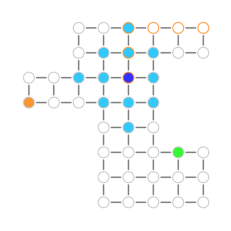

findfont: Font family ['Calibri'] not found. Falling back to DejaVu Sans.


0 7 0 7
0 7 0 7


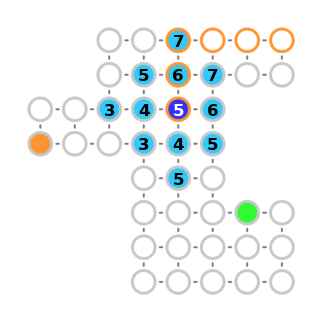

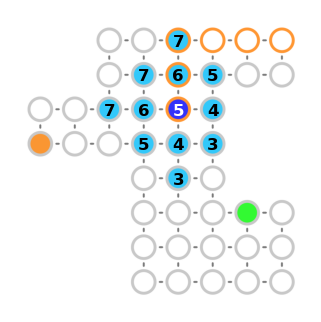

In [3]:
import networkx as nx

landscape = landscaping.load_landscape('gridworlds/square_rect_based/8x8E.tmx', vf_movement_penalty=0, vf_goal_initial_value=1, vf_discount_factor=0.99)

agent_example_pos = (2, 4)
graph = landscape.graph
subgraph = nx.ego_graph(landscape.graph, agent_example_pos, radius=2)

node_colors = {
    node: (50, 200, 250) if node in subgraph.nodes else (255, 255, 255)
    for node in graph.nodes
}
node_colors[agent_example_pos] = (50, 50, 250)
node_colors[landscape.available_goals[0]] = (250, 150, 50)
node_colors[landscape.available_goals[1]] = (50, 250, 50)
outline_colors = {
    node: (200, 200, 200) for node in graph.nodes
}
for node in [(0,7),(0,6),(0,5),(0,4),(1,4),(2,4)]:
    outline_colors[node] = (255, 150, 50)
print(landscape.available_goals)

result = graph_rendering.render_graph_v2(
    graph,
    landscape.layout,
    1200,
    node_colors=node_colors,
    outline_colors=outline_colors,
    node_size=30,
    edge_thickness=5,
)

plt.rcParams['figure.dpi'] = 100
plt.axis('off')
plt.imshow(result)
plt.show()

result = graph_rendering.render_graph_v2(
    graph,
    landscape.layout,
    1200,
    node_colors=node_colors,
    outline_colors=outline_colors,
    outline_thickness=10,
    node_size=45,
    edge_thickness=5,
)

pos = graph_rendering.normalize_pos_dict_square(landscape.layout, 1200)
pos = {node: tuple(int(x) for x in pos[node]) for node in pos}

plt.rcParams['figure.dpi'] = 100
plt.axis('off')
plt.imshow(result)
for node in subgraph:
    x,y = pos[node]
    # align center
    d = nx.shortest_path_length(graph, landscape.available_goals[0], node)
    plt.text(x, y+8, str(d), ha="center", va="center", color="white" if node == agent_example_pos else "black", fontsize=12, fontweight="bold", fontname="Calibri")
plt.show()

plt.rcParams['figure.dpi'] = 100
plt.axis('off')
plt.imshow(result)
for node in subgraph:
    x,y = pos[node]
    # align center
    d = nx.shortest_path_length(graph, landscape.available_goals[1], node)
    plt.text(x, y+8, str(d), ha="center", va="center", color="white" if node == agent_example_pos else "black", fontsize=12, fontweight="bold", fontname="Calibri")
plt.show()


## Creating inference / graph architecture figure

Inspired by the figure for GraphSAGE, which squeezes in the feature vectors for each node and then shows which ones are used for inference.

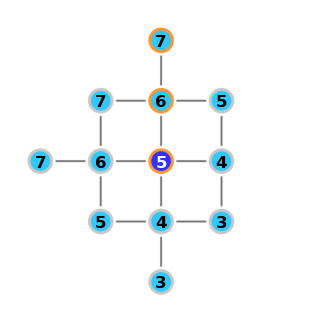

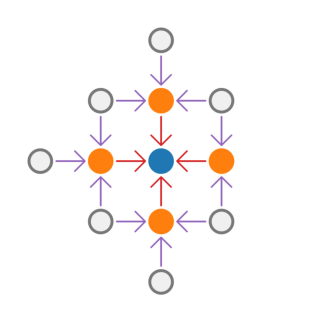

In [30]:
imsz = 1200
subgraph_pos_dict = {n: landscape.layout[n] for n in subgraph.nodes}
subgraph_pos_dict = graph_rendering.normalize_pos_dict_square(subgraph_pos_dict, imsz)

node_colors: dict = {
    node: (50, 200, 250) if node in subgraph.nodes else (255, 255, 255)
    for node in graph.nodes
}
node_colors[agent_example_pos] = (50, 50, 250)
node_colors[landscape.available_goals[0]] = (250, 150, 50)
node_colors[landscape.available_goals[1]] = (50, 250, 50)
outline_colors: dict = {
    node: (200, 200, 200) for node in graph.nodes
}
for node in [(0,7),(0,6),(0,5),(0,4),(1,4),(2,4)]:
    outline_colors[node] = (255, 150, 50)

result = graph_rendering.render_graph_v2(
    subgraph,
    subgraph_pos_dict,
    imsz,
    node_colors=node_colors,
    outline_colors=outline_colors,
    outline_thickness=10,
    node_size=45,
    edge_thickness=5,
)

plt.rcParams['figure.dpi'] = 100
plt.axis('off')
plt.imshow(result)
for node in subgraph:
    x,y = subgraph_pos_dict[node]
    # align center
    d = nx.shortest_path_length(graph, landscape.available_goals[1], node)
    plt.text(x, y+8, str(d), ha="center", va="center", color="white" if node == agent_example_pos else "black", fontsize=12, fontweight="bold", fontname="Calibri")
plt.show()

# Setting nodes
node_colors: dict = {
    node: (240, 240, 240) for node in subgraph.nodes
}
# node_colors[agent_example_pos] = (50, 50, 250)

# Setting edges
arrows = []
edge_colors = {}
edge_color_palette = plt.get_cmap("tab10")
to_255 = lambda x: tuple([int(255 * c) for c in edge_color_palette(x)])[:3]

for node in nx.ego_graph(subgraph, agent_example_pos, 2):
    depth = nx.shortest_path_length(subgraph, node, agent_example_pos)
    if depth < 2:
        outline_colors[node] = to_255(depth)
        node_colors[node] = to_255(depth)
    else:
        outline_colors[node] = (120, 120, 120)
    for neighbor in nx.neighbors(subgraph, node):
        L = nx.shortest_path_length(subgraph, node, agent_example_pos)
        if nx.shortest_path_length(subgraph, neighbor, agent_example_pos) < L:
            arrows.append((node, neighbor))
            edge_colors[(node, neighbor)] = to_255(L + 2)
            edge_colors[(neighbor, node)] = to_255(L + 2)

result = graph_rendering.render_graph_v2(
    subgraph,
    subgraph_pos_dict,
    imsz,
    node_colors=node_colors,
    outline_colors=outline_colors,
    edge_colors=edge_colors,
    outline_thickness=10,
    node_size=45,
    edge_thickness=5,
    arrows=arrows,
)

plt.rcParams['figure.dpi'] = 100
plt.axis('off')
plt.imshow(result)
for node in subgraph:
    x,y = subgraph_pos_dict[node]
    # align center
    d = nx.shortest_path_length(graph, landscape.available_goals[1], node)
    # plt.text(x, y+8, str(d), ha="center", va="center", color="white" if node == agent_example_pos else "black", fontsize=12, fontweight="bold", fontname="Calibri")
plt.show()
